In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

### Implementation of Convolutional Variational Autoencoder with TensorFlow


In [0]:
class ConvolutionalVAE(tf.keras.Model):

  def __init__(self, latent_dim):
    super(ConvolutionalVAE, self).__init__()
    self.latent_dim = latent_dim
    self._conv_common_params = {
        'kernel_size': 3,
        'strides': (2, 2),
        'padding': 'same',
        'activation': 'relu'
        }
    self._encoder = None
    self._decoder = None

  @property
  def encoder(self):
    """ Returns encoder network """
    if self._encoder:
      return self._encoder

    input = tf.keras.Input(shape=(28, 28, 1))

    x = tf.keras.layers.Conv2D(32, **self._conv_common_params)(input)
    x = tf.keras.layers.Conv2D(64, **self._conv_common_params)(x)
    
    x = tf.keras.layers.Flatten()(x)
    
    # reparametrisarion trick
    mean   = tf.keras.layers.Dense(units=self.latent_dim)(x)
    logvar = tf.keras.layers.Dense(units=self.latent_dim)(x)

    epsilon = tf.random.normal(shape=[self.latent_dim])
    z = mean + tf.exp(logvar / 2) * epsilon

    self._encoder = tf.keras.models.Model(input, [mean, logvar, z], name='encoder')

    return self._encoder

  @property
  def decoder(self):
    """ Return decoder network """
    if self._decoder:
      return self._decoder

    input = tf.keras.Input(shape=(self.latent_dim, ))

    x = tf.keras.layers.Dense(units = 7 * 7 * 32, activation=tf.nn.relu)(input)
    x = tf.keras.layers.Reshape(target_shape=(7, 7, 32))(x)

    x = tf.keras.layers.Conv2DTranspose(64, **self._conv_common_params)(x)
    x = tf.keras.layers.Conv2DTranspose(32, **self._conv_common_params)(x)

    x = tf.keras.layers.Conv2DTranspose(1, 3, strides=(1, 1), padding='same')(x)

    self._decoder = tf.keras.models.Model(input, x, name='decoder')

    return self._decoder

  def _evaluate_log_normal(self, z, mean, logvar):
    """ Evaluates value of log normal distribution in point z """
    exp_term = - 1 / 2 * (z - mean) ** 2. * tf.exp(-logvar)
    weight_term = - logvar - 1 /2 * tf.math.log(2. * np.pi)

    return tf.reduce_sum(exp_term + weight_term, axis=1)

  def elbo_loss(self, x):
    mean, logvar, z = self.encoder(x)
    x_predicted = self.decoder(z)

    # Monte Carlo estimates
    # TODO: KL-divergence
    log_px_z = -tf.reduce_sum(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=x_predicted, 
            labels=x), 
        axis=[1, 2, 3])
    log_pz = self._evaluate_log_normal(z, 0., 0.)
    log_qz_x = self._evaluate_log_normal(z, mean, logvar)

    return -tf.reduce_mean(log_px_z + log_pz - log_qz_x)

  def train(self, x, optimizer):
    with tf.GradientTape() as tape:
      loss = self.elbo_loss(x)
    gradients = tape.gradient(loss, self.trainable_variables)
    optimizer.apply_gradients(zip(gradients, self.trainable_variables))

  @tf.function
  def sample(self, random_sample):
    if random_sample is None:
      random_sample = tf.random.normal(shape=(5, self.latent_dim))
    return self.decoder(random_sample)

#### Loading dataset

In [0]:
(X_train, _), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

# Normalizing the images to the range of [0., 1.]
X_train /= 255.
X_test /= 255.

# Binarization
X_train[X_train >= .5] = 1.
X_train[X_train < .5] = 0.

X_test[X_test >= .5] = 1.
X_test[X_test < .5] = 0.

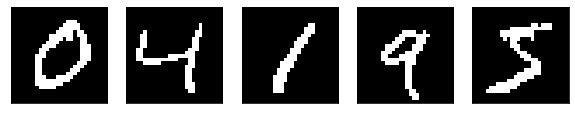

In [4]:
n_samples_show = 5
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

for i in range(n_samples_show):
    axes[i-1].imshow(X_train[i][:,:,0], cmap='gray')
    axes[i-1].set_xticks([])
    axes[i-1].set_yticks([])

In [0]:
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_dataset = train_dataset.shuffle(len(X_train))
train_dataset = train_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_dataset = test_dataset.shuffle(len(X_test))
test_dataset = test_dataset.batch(batch_size)

In [6]:
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Training [	0%	]	Loss: 101.6516


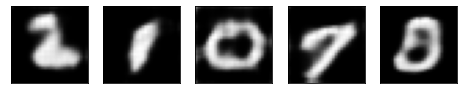

Training [	13%	]	Loss: 65.7478


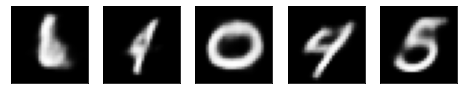

Training [	27%	]	Loss: 57.9281


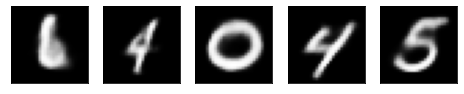

Training [	40%	]	Loss: 57.9742


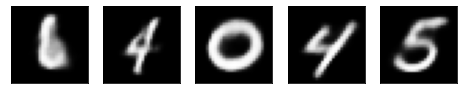

Training [	53%	]	Loss: 53.4778


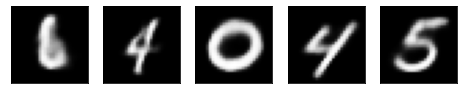

Training [	67%	]	Loss: 54.3598


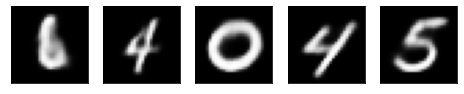

Training [	80%	]	Loss: 54.2405


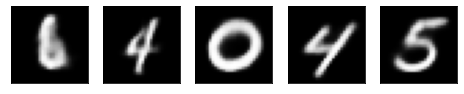

Training [	93%	]	Loss: 57.7416


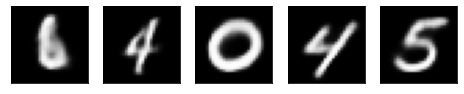

In [7]:
epochs = 150
latent_dim = 5

model = ConvolutionalVAE(latent_dim)
optimizer = tf.keras.optimizers.Adam(1e-4)

losses = []
random_sample = tf.random.normal(shape=(n_samples_show, latent_dim))

with tf.device('/device:GPU:0'):
  for epoch in range(epochs):
    for x in train_dataset:
      model.train(x, optimizer)

    if epoch % 20 == 0:
      loss = tf.keras.metrics.Mean()

      for x in test_dataset:
        loss(model.elbo_loss(x))

      print('Training [\t{:.0f}%\t]\tLoss: {:.4f}'.format(
          100. * epoch / epochs, loss.result()))
      losses.append(loss.result())

      fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(8, 2))
      
      predictions = tf.sigmoid(model.sample(random_sample))

      for i in range(n_samples_show):
        axes[i-1].imshow(predictions[i,:,:,0], cmap='gray')
        axes[i-1].set_xticks([])
        axes[i-1].set_yticks([])

      plt.show()

Training loss plot

Text(0, 0.5, 'ELBO Loss')

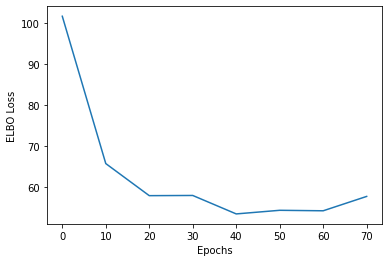

In [8]:
plt.plot(np.arange(len(losses)) * 10, losses)
plt.xlabel('Epochs')
plt.ylabel('ELBO Loss')

Testing input - prediction correspondance

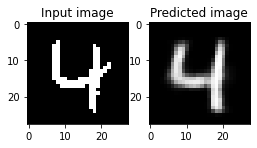

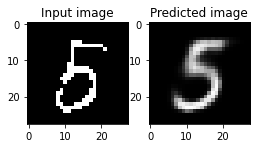

In [9]:
def test_image(img):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(4, 2))

  mean, _, latent_variables = model.encoder(np.expand_dims(img, axis=0).astype('float32'))
  predicted_img = tf.sigmoid(model.decoder(latent_variables))
  axes[0].imshow(img[:,:,0], cmap='gray')
  axes[0].set_title('Input image')
  axes[1].imshow(predicted_img[0,:,:,0], cmap='gray')
  axes[1].set_title('Predicted image')


test_image(X_test[np.random.randint(100)])
test_image(X_test[np.random.randint(100)])

### Visualising latent space

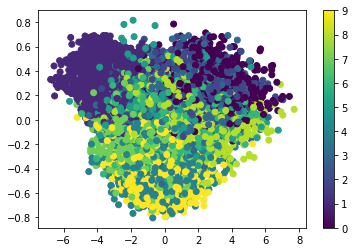

In [10]:
means, _, _ = model.encoder(X_test)

pca = PCA(n_components=2)
latent_vals = pca.fit_transform(means)

plt.scatter(latent_vals[:, 0], latent_vals[:, 1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()

### Literature
1. http://louistiao.me/posts/implementing-variational-autoencoders-in-keras-beyond-the-quickstart-tutorial/
2. https://www.tensorflow.org/tutorials/generative/cvae